# dask.delayed - paralelização de código python

Vamos explorar a prática de programação paralela via dask com um exemplo simples de código Python. No âmbito de dask, precisamos que as funções sejam avalidas de maneira preguiçosa (/lazy evaluation/). Para isso, empregaremos o operador `@delayed`.

**Documentação adicional**

* [Delayed documentação](https://docs.dask.org/en/latest/delayed.html)
* [Delayed tutorial rápido](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed exemplos](https://examples.dask.org/delayed.html)
* [Delayed melhores práticas](https://docs.dask.org/en/latest/delayed-best-practices.html)

Veremos mais adiante como criar um escalonador que distribuirá as tarefas no cluster de máquinas. Como vimos, existem várias formas de fazer isso. Nesta prática, vamos apenas instanciar um cliente com trabalhadores locais.

In [1]:
!pip install graphviz
# !pip install ipycytoscape

In [2]:
from dask.distributed import Client
client = Client(n_workers=4)

## Um workflow típico de análise de dados

Um workflow de análise de dados registrado em arquivos topicamente tem a forma abaixo. Esse tipo de código pode beneficiar da avaliação preguiçosa com a diretiva `@dask.delayed`. O exemplo seguinte ilustra a leitura - transformação - escrita:

```python
import dask
    
@dask.delayed
def process_file(filename):
    data = read_a_file(filename)
    data = do_a_transformation(data)
    destination = f"results/{filename}"
    write_out_data(data, destination)
    return destination

results = []
for filename in filenames:
    results.append(process_file(filename))
    
dask.compute(results)
```

## Início da prática

Vamos definir duas funções, `inc` a `add`, que tem uma funcionalidade de incremento e adição mas que ambas dormem (através da chamada `sleep`) por um segundo cada vez que uma é chamada. Podemos imaginar que a chamada à `sleep` pode representar um tempo de cálculo.

In [3]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

Vamos medir o tempo de execução deste código sequencial usando a anotação `%%time`, um incremento fornecido pelo Jupyter Notebook.

In [4]:
%%time
# Este código leva três segundos para ser executado
# por que nós chamamos as funções de maneira sequencial.

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 285 ms, sys: 25.2 ms, total: 310 ms
Wall time: 3 s


### Paralelização com o decorador `dask.delayed`

As chamadas ao incremento *poderiam* ser invocadas em parapelo, porque elas são totalmente independentes entre si.

Vamos transformar as duas funções `inc` e `add` em funções preguiçosas usando o decorador `dask.delayed`. Quando nós chamarmos a versão *delayed* com passagem de argumentos, exatamente como antes, a função original não é de fato executada. É por causa disso que a execução do bloco abaixo termina quase de maneira instantânea. Ao invés do resultado, obtemos um *objeto atrasado*, que tem em si as funções que devem ser chamadas e os seus argumentos.

In [5]:
import dask

@dask.delayed
def inc(x):
    sleep(1)
    return x + 1

@dask.delayed
def add(x, y):
    sleep(1)
    return x + y

In [19]:
%%time
# Este código executa quase de maneira instantânea
# A única coisa que ele faz é construir o *grafo de tarefas*

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 1.16 ms, sys: 311 µs, total: 1.47 ms
Wall time: 942 µs


Como podemos ver, executou em 6.25 microsegundos (ms), uma vez nada foi efetivamente executado.

Para efetivamente obter o resultado, chamamos o método `compute` no objeto `z` retornado. Podemos perceber que isso executa mais rápido que o código original.

In [20]:
%%time
# Isto de fato executa o cálculo solicitado
# utilizando as threads locais (criadas no cliente)

z.compute()

CPU times: user 7.03 ms, sys: 3.61 ms, total: 10.6 ms
Wall time: 2.01 s


5

## O que aconteceu?

O objeto `z`  é um objeto `delayed` preguiçoso. Este objeto guarda em si todo o necessário para calcular o resultado final, incluindo referências para todas as funções necessárias para o cálculo, como as entradas e as relações entre as funções. Nós podemos avaliar o resultado com o método `.compute()` como fizemos acima, mas nós podemos também visualizar o **grafo de tarefas** para o valor que será criado com o método `visualize()`.

In [8]:
z

Delayed('add-959ce7e3-47c8-4be6-90dd-94332df93dd7')

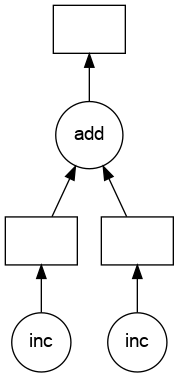

In [9]:
# Look at the task graph for `z`
z.visualize()

Percebemos que nomes das funções como antes (na forma de círculos nomeados), e o fluxo de dados lógico das entradas/saídas (na forma de retângulos sem nomes). Vemos que a saída das duas instâncias de `inc` são a entrada para a função `add`, como havia estava no código que escrevemos para gerar `z`.

### Algumas questões para discussão

- Por que reduzimos o tempo de 3s para 2s?
- Por que não conseguimos reduzir para 1s?
- Sem o `sleep(1)`, seria ainda possível melhorar o tempo de execução?
- E se precisássemos acessar os resultados intermediários (`x` e `y`)?

## Paralelização de Laços for

Laços `for` contém partes do código mais comuns que podemos paralelizar, especialmente se as iterações são **independentes entre si**. Podemos usar a função `dask.delayed` diretamente na chamada de uma função para torná-la *lazy*, passando como primeiro parâmetro a função a ser transformada em "preguiçosa", e os  demais parâmetros representando as entradas da função.

Vamos testar diferentes formas de paralelização no laço for abaixo:
1. Adicionando `@dask.delayed` na definição da função `inc`
2. Na chamada da função `inc`, torná-la *lazy*
3. Fazer com em 2, adicionalmente na chamada da função `sum`, torná-la *lazy*

In [10]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [11]:
%%time

def inc(x):
    sleep(1)
    return x + 1

# Vamos paralelizar o laço for de diferentes formas e ver o resultado no grafo
results = []
for x in data:
    y = inc(x)
    results.append(y)

total = sum(results)
total

CPU times: user 837 ms, sys: 138 ms, total: 976 ms
Wall time: 8.01 s


44

Vamos agora usar a definição de `inc` com `@dask.delayed`, fazendo a soma das respostas de duas chamadas subsequentes à `inc` (como ilustrado no código abaixo). Discutimos o que acontece assumindo que `inc` é uma função preguiçosa. Observamos como o operador `+` é transformando também em uma operação avaliada de maneira preguiçosa.

CPU times: user 5.74 ms, sys: 0 ns, total: 5.74 ms
Wall time: 30.4 ms


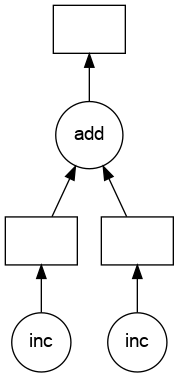

In [12]:
%%time
@dask.delayed
def inc(x):
    sleep(1)
    return x + 1

soma = inc(1) + inc(2)
soma.visualize()

## Paralelização de laços `for` com controle de fluxo

Frequentemente queremos atrasar somente *algumas* funções, rodando outras de maneira imediata. Isto é especialmente importante quando algumas funções são rápidas e nos ajudam a determinar quais outras funções lentas devemos chamar. Esta decisão, de atrasar ou não atrasar, é usualmente onde nós precisamos ser cuidadosos ao usar `dask.delayed`.

No exemplo abaixo, nós iteramos por uma lista de elementos registrados em `data`. Se o valor do elemento é par, então nós chamamos `inc`. Se for ímpar, nós chamamos `double`. Esta decisão se o elemento é par ou ímpar esta implementado na função `is_even`, e sua resposta usamos para decidir se chamamos `inc` ou `double`. A decisão deve ser feita imediatamente (de maneira *não preguiçosa*) de maneira que podemos completar a construção do grafo de tarefas completo para todo o laço for.

In [13]:
def double(x):
    sleep(1)
    return 2 * x

def inc(x):
    sleep(1)
    return x + 1

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [14]:
%%time
# Código sequencial

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)

total = sum(results)
print(total)

90
CPU times: user 981 ms, sys: 141 ms, total: 1.12 s
Wall time: 10 s


In [15]:
@dask.delayed
def double(x):
    sleep(1)
    return 2 * x

@dask.delayed
def inc(x):
    sleep(1)
    return x + 1

results = []
for x in data:
    if is_even(x):  # even
        y = double(x)
    else:  # odd
        y = inc(x)
    results.append(y)

total = dask.delayed(sum)(results)

In [16]:
%time total.compute()

CPU times: user 246 ms, sys: 42.7 ms, total: 288 ms
Wall time: 2.08 s


90

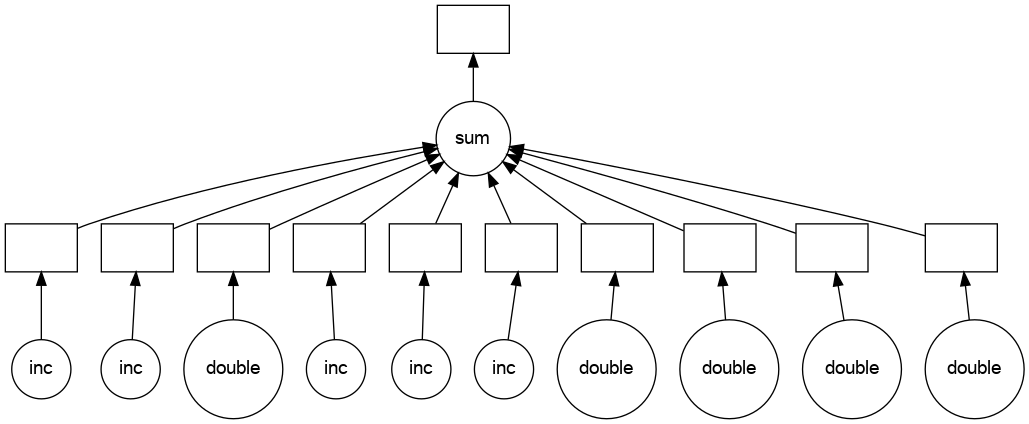

In [17]:
total.visualize()

### Algumas questões para considerarmos

-  O que teria acontecido se nós tivéssemos atrasado a avaliação da função `is_even(x)`?

## Fechar o cliente

Vamos nos assegurar de encerrar o cliente.

In [18]:
client.close()